## This notebook walks through the basics of generating synthetic choice data and fitting the model to that data to recover the paramaters that generated it

Fitting these models to data to choice data alone can be computational expensive. We fit the model below using 44 cpus.

In [1]:
using Distributed
addprocs(44);

### Fitting a choice model.

First you have to include the necessary packages

In [3]:
using PulseInputDDM, Flatten

### Generate some data

Create an instance of the `θchoice` [composite type](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) which contains the 9 parameters of a choice DDM model. 

In [4]:
θ_syn = θchoice(θz=θz(σ2_i = 1., B = 13., λ = -0.5, σ2_a = 10., σ2_s = 1.0,
    ϕ = 0.4, τ_ϕ = 0.02), bias=0.1, lapse=0.1);

In [5]:
xgen = collect(Flatten.flatten(θ_syn));

Generate the synthetic data using those parameters

In [6]:
_, data = synthetic_data(;θ=θ_syn, ntrials=20_000, rng=2, dt=1e-2);

Use 53 spatial bins for approximating the distribution of the latent

In [7]:
n = 53

53

Create an instance of the `choiceDDM` composite type which contains the parameters and the data of a choice DDM model. 

In [8]:
model = choiceDDM(θ=θ_syn, data=data, n=n);

Compute the loglikelihood of the model under the generative parameters

In [9]:
loglikelihood(model)

-7448.29304304485

random initial state

In [10]:
x0 = vcat([0.1, 15., -0.1, 20., 0.5, 0.2, 0.008], [0.,0.01]);

use `Flatten.reconstruct` to place the intial state into the `θchoice()` type, with each variable going into the right place

In [11]:
θ = Flatten.reconstruct(θchoice(), x0)

θchoice{θz{Float64},Float64}
  θz: θz{Float64}
  bias: Float64 0.0
  lapse: Float64 0.01


In [12]:
model = choiceDDM(θ=θ, data=data, n=n);

Compute the loglikelihood of the model under the initial parameters

In [13]:
loglikelihood(model)

-8712.263830160397

Create an instance of the `choiceoptions` composite type, using all the default values. `choiceoptions` specifes which parameters to fit, and the lower and upper bounds of the optimization.

In [14]:
options = choiceoptions()

choiceoptions
  fit: Array{Bool}((9,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((9,)) [0.0, 4.0, -5.0, 0.0, 0.0, 0.01, 0.005, -5.0, 0.0]
  ub: Array{Float64}((9,)) [30.0, 30.0, 5.0, 100.0, 2.5, 1.2, 1.0, 5.0, 1.0]


### Optimize the model, using the options to define details of the optimization

In [15]:
model, = optimize(model, options, f_tol=1e-12)

Fminbox
-------
Initial mu = 0.387936

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.387936

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     8.719094e+03     1.233976e+05
 * time: 1.7881393432617188e-5
    10     7.441270e+03     2.124103e+02
 * time: 126.31541991233826
    20     7.440005e+03     7.602197e+01
 * time: 233.1365339756012
    30     7.439966e+03     3.169991e+00
 * time: 344.88973689079285
    40     7.439963e+03     4.065068e-02
 * time: 458.33810091018677

Exiting inner optimizer with x = [8.278171038031775, 10.980263064270213, -0.7535134909419896, 11.170935536353571, 0.4982053626489453, 0.3161414869501754, 0.019630825382048595, 0.014215529270691854, 0.09720093339278836]
Current distance to box: 0.0146308
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 0.000387936

(numbers below include barrier contribution)
Iter     Function value   Gra

(choiceDDM{θchoice{θz{Float64},Float64},Array{PulseInputDDM.choicedata{PulseInputDDM.choiceinputs{PulseInputDDM.clicks,PulseInputDDM.binned_clicks}},1},θprior{Float64}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{PulseInputDDM.choicedata{PulseInputDDM.choiceinputs{PulseInputDDM.clicks,PulseInputDDM.binned_clicks}}}((20000,))
  n: Int64 53
  cross: Bool false
  θprior: θprior{Float64}
,  * Status: success

 * Candidate solution
    Final objective value:     7.445892e+03

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 1.28e-07 ≰ 1.0e-10
    |x - x'|/|x'|          = 8.15e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-12
    |g(x)|                 = 1.58e-03 ≰ 1.0e-03

 * Work counters
    Seconds run:   1078  (vs limit 170000)
    Iterations:    4
    f(x) calls:    153
    ∇f(x) calls:   86
)

Compute the likelihood of the optimized model

In [17]:
loglikelihood(model)

-7435.988771955865

Compute the gradient of the model after optimization, to ensure we are near the minimum of the loglikelihood

In [18]:
gradient(model)

9-element Array{Float64,1}:
  0.00023203194691347184
 -0.0003739649905023512
  0.00011149134739874
  2.3703600912500233e-5
  0.00024346462880586728
  0.001582986888722715
  0.0014750331932305016
  1.5681682402401975e-5
 -0.001246698844674654

Compute the Hessian of the model, to compute confidence bounds around the ML parameters

In [19]:
H = Hessian(model)
CI, HPSD = CIs(H);

Check the eigenvalues of the hessian, to ensure that it is positive semidefinite

In [20]:
using LinearAlgebra
eigvals(H)

9-element Array{Float64,1}:
     0.006730854607105812
     0.03165441999732431
     0.1631166553039767
    30.55369867983586
    81.01079285050298
   171.8784174470118
   204.71339280120787
 38564.622428595365
     2.2725408204175234e6

In [21]:
xf = collect(Flatten.flatten(model.θ));

Check that the solution is within the confidence intervals

In [22]:
(xf - CI) .< xgen, (xf + CI) .> xgen

(Bool[1, 1, 1, 1, 1, 1, 1, 1, 1], Bool[1, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
lb = options.lb
ub = options.ub;

Compute the LL over the optimization domain, for plotting

In [24]:
@everywhere ℓℓ(x, model) = -PulseInputDDM.loglikelihood(x, model)

In [25]:
αs = hcat(map((lb,ub)-> range(lb + eps(), stop=ub, length=30), lb, ub));

In [26]:
LL_scan = map(i-> map(x-> ℓℓ(vcat(xf[1:i-1], x, xf[i+1:end]), model), αs[i]), 1:9);

In [27]:
using PyPlot

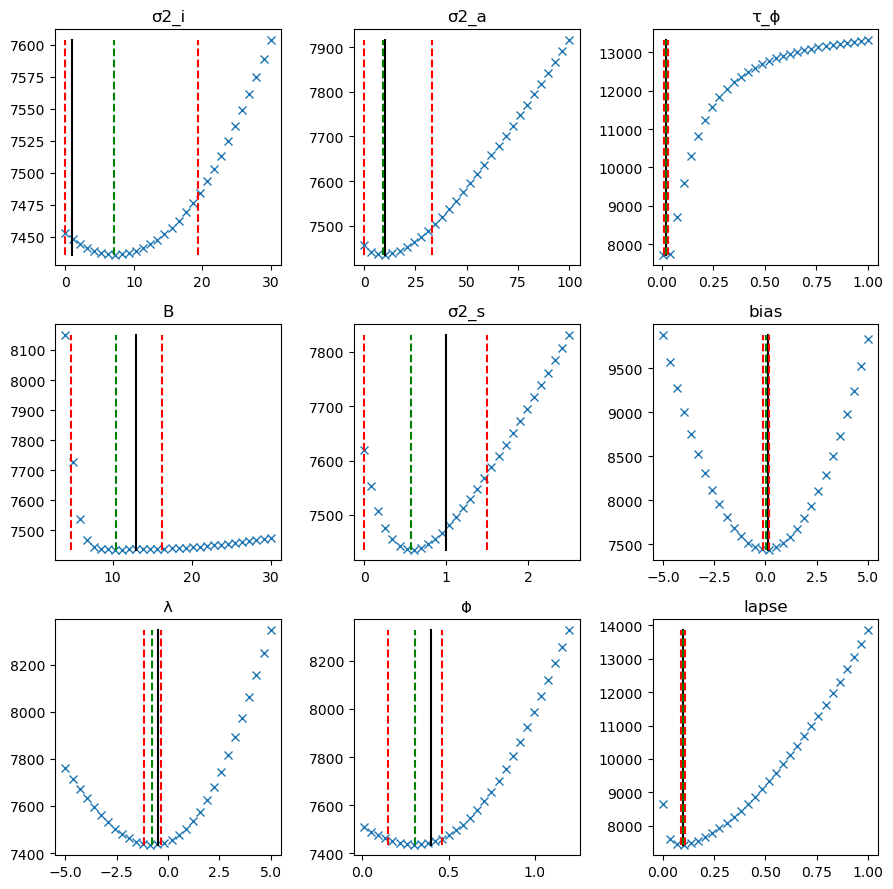

In [28]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(αs[i], LL_scan[i], "x")
    ax[i].set_title(name[i])
    ax[i].plot(xgen[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100), "k")
    ax[i].plot(xf[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100),
        "g--")
    ax[i].plot(max((xf[i] - CI[i]), lb[i]) *ones(100), range(minimum(LL_scan[i]), 
            stop=maximum(LL_scan[i]), length=100), "r--")
    ax[i].plot(min((xf[i] + CI[i]), ub[i]) *ones(100), range(minimum(LL_scan[i]), 
            stop=maximum(LL_scan[i]), length=100), "r--")

    
end

tight_layout() 

## Saving and reloading modeling results and saving data

Use the `save_choice_model` function to save the optimized model, the options used to define the optimization, and the confidence intervals

In [29]:
save_file = "../choice model/example_results.mat"
save_choice_model(save_file, model, options, CI)

if you want to restart the optimization from where you stopped `reload_choice_model` will reload those model parameters and the `options`

In [30]:
θ, options = reload_choice_model(save_file);

Save the choice data using `save_choice_data` and then reload it using `load_choice_data`

In [31]:
import PulseInputDDM: save_choice_data

In [32]:
save_choice_data("../choice model/example_matfile_2.mat", data)

In [33]:
data = load_choice_data("../choice model/example_matfile_2.mat");

In [34]:
model = choiceDDM(θ=θ, data=data, n=n);
loglikelihood(model)

-7435.988771955865

## Loading data and fitting a choice model from real data

Because many neuroscientists use matlab, we use the [MAT.jl](https://github.com/JuliaIO/MAT.jl) package for IO. Data can be loaded using two conventions. One of these conventions is easier when data is saved within matlab as a .MAT file, and is described below. 

The package expects your data to live in a single .mat file which should contain a struct called `rawdata`. Each element of `rawdata` should have data for one behavioral trial and `rawdata` should contain the following fields with the specified structure:

 - `rawdata.leftbups`: row-vector containing the relative timing, in seconds, of left clicks on an individual trial. 0 seconds is the start of the click stimulus.
 - `rawdata.rightbups`: row-vector containing the relative timing in seconds (origin at 0 sec) of right clicks on an individual trial. 0 seconds is the start of the click stimulus.
 - `rawdata.T`: the duration of the trial, in seconds. The beginning of a trial is defined as the start of the click stimulus. The end of a trial is defined based on the behavioral event “cpoke_end”. This was the Hanks convention.
 - `rawdata.pokedR`: `Bool` representing the animal choice (1 = right).
 
The example file located at `../choice model/example_matfile.mat` adheres to this convention and can be loaded using the `load_choice_data` method.

In [37]:
data = load_choice_data("../choice model/example_matfile.mat");

In [38]:
θ2 = θchoice(θz=θz(σ2_i = 2., B = 23., λ = 0.5, σ2_a = 100., σ2_s = 1.1,
    ϕ = 0.35, τ_ϕ = 0.035), bias=0.2, lapse=0.01);

In [39]:
model = choiceDDM(θ=θ2, data=data, n=n);
loglikelihood(model)

-4.321480367653435